# Hyperparameter Optimization

Tune Ridge alphas and RNN architecture for numerical prediction.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
%matplotlib inline

In [3]:
# Feature sets
lin_feats = ['activity', 'appCat.communication', 'appCat.utilities', 'call', 'circumplex.valence', 'mood', 'sms', 'screen_log', 'activity_log', 'call_sms_ratio']
rnn_feats = ['appCat.communication', 'screen', 'appCat.builtin', 'appCat.finance', 'appCat.unknown', 'mood']

In [4]:
# Load data
df = pd.read_pickle('df_feat.pkl')
X_lin = df[lin_feats]
X_rnn = df[rnn_feats]
y = df['nextday']
# Train/test split for both
X_train_lin, X_test_lin, y_train, y_test = train_test_split(X_lin, y, test_size=0.2, random_state=42)
X_train_rnn, X_test_rnn, _, _ = train_test_split(X_rnn, y, test_size=0.2, random_state=42)

## Ridge Regression Tuning
Use GridSearchCV to find the best alpha.

In [5]:
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train_lin, y_train)
print('Best alpha:', grid.best_params_['ridge__alpha'])
print('CV MSE:', -grid.best_score_)
pred = grid.predict(X_test_lin)
print('Test MSE:', mean_squared_error(y_test, pred))

Best alpha: 10
CV MSE: 0.42823247842190293
Test MSE: 0.511728507978285


## RNN Architecture Tuning
Manual grid search over number of units and dropout.

In [8]:
# Prepare RNN data
X_tr = X_train_rnn.values.reshape(len(X_train_rnn), 1, len(rnn_feats))
X_te = X_test_rnn.values.reshape(len(X_test_rnn), 1, len(rnn_feats))
results = []
for units in [10, 50, 100, 500]:
    for dr in [0.01, 0.1, 0.3]:
        model = Sequential()
        model.add(SimpleRNN(units, input_shape=(1, len(rnn_feats)), activation='tanh'))
        model.add(Dropout(dr))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_tr, y_train, epochs=20, batch_size=32, verbose=0)
        mse = model.evaluate(X_te, y_test, verbose=0)
        results.append({'units': units, 'dropout': dr, 'mse': mse})
results_df = pd.DataFrame(results)
display(results_df.sort_values('mse').head())

,units,dropout,mse
9,500,0.01,0.643381
10,500,0.10,0.666996
11,500,0.30,0.717158
8,100,0.30,0.717547
7,100,0.10,0.868890


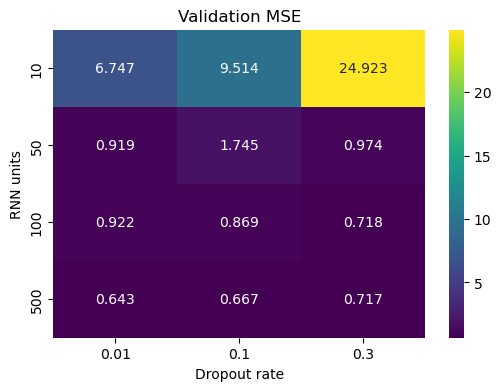

In [9]:
import seaborn as sns

# Pivot MSEs into a matrix
heat = results_df.pivot(index='units', columns='dropout', values='mse')

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(heat, annot=True, fmt='.3f', cmap='viridis')
plt.xlabel('Dropout rate')
plt.ylabel('RNN units')
plt.title('Validation MSE')
plt.show()